Read data and reconstruct image

In [1]:
from ptuio.reader import TTTRReader
from ptuio.utils import estimate_tcspc_bins
from ptuio.decoder import T3OverflowCorrector
from ptuio.reconstructor import ScanConfig, ImageReconstructor

import numpy as np

reader = TTTRReader("../test/data/MultiHarp150_2025-06-18_16-34-21.822_f1_ch1_accu4_px500.ptu")
cfg = ScanConfig(
    frames= 1,
    lines=500, 
    pixels=500, 
    line_accumulations= (4,),
    max_detector=1
    )

wrap = reader.header.tags.get("TTResultFormat_WrapAround", 1024)  # default fallback
repetition_rate = reader.header.tags.get("TTResult_SyncRate",40e6)  
tcspc_resolution = reader.header.tags.get("MeasDesc_Resolution",5e-12)
tcspc_bins = estimate_tcspc_bins(reader.header.tags,buffer=0)
TCSPCresol = reader.header.tags.get("MeasDesc_Resolution")

corrector = T3OverflowCorrector(wraparound=wrap)
omega = 2 * np.pi * repetition_rate * tcspc_resolution # should be in channel units

reconstructor = ImageReconstructor(
    config=cfg, 
    omega=omega, 
    tcspc_channels= tcspc_bins,
    )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()


Reconstruction finished.


Get variables from the result

In [2]:
count = result.photon_count.transpose("frame","sequence","channel","line","pixel")
lifetime = result.mean_arrival_time.transpose("frame","sequence","channel","line","pixel")
g = result.phasor_g.transpose("frame","sequence","channel","line","pixel")
s = result.phasor_s.transpose("frame","sequence","channel","line","pixel")
decay = result.tcspc_histogram

# Slice
count = count.isel(frame=0,sequence=0,channel=0)
lifetime = lifetime.isel(frame=0,sequence=0,channel=0)
g = g.isel(frame=0,sequence=0,channel=0)
s = s.isel(frame=0,sequence=0,channel=0)
decay = decay.isel(frame=0,channel=0)

# Convert to numpy
count = np.array(count,dtype=int)
lifetime = np.array(lifetime * tcspc_resolution, dtype = float)
g = np.array(g,dtype=float)
s = np.array(s,dtype=float)
phasor = (g + 1j * s).astype(complex)



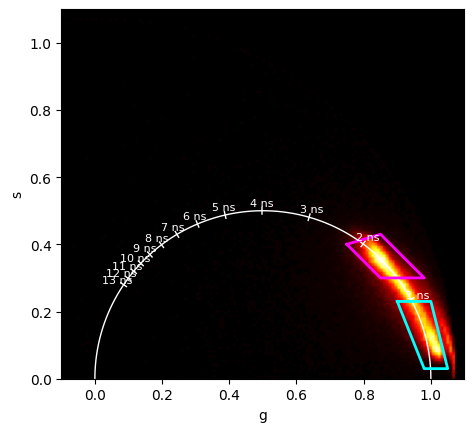

In [3]:
import numpy as np
from ptuio.utils import smooth_phasor, draw_unitary_circle
import matplotlib.pyplot as plt

# Calibration: see phasor_calibration.ipynb notebook
calibration_factor = 1.0087915993575935-0.3623240433091721j

phasor_calibrated = phasor * calibration_factor

phasor_calibrated_smoothed = smooth_phasor(phasor_calibrated,count)

valid = valid = np.isfinite(phasor) & (count > 0)


g_calibrated_smooth_valid = phasor_calibrated_smoothed[valid].real
s_calibrated_smooth_valid = phasor_calibrated_smoothed[valid].imag


H, xedges, yedges = np.histogram2d(g_calibrated_smooth_valid, s_calibrated_smooth_valid, bins=250)
# Create alpha mask: transparent where H == min(H)
alpha = np.ones_like(H, dtype=float)
alpha[H == H.min()] = 0.0

fig, ax = plt.subplots()

im = ax.imshow(
    H.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='hot',
    aspect='equal',
    alpha=alpha.T  # transpose alpha to match H.T
)
draw_unitary_circle(ax,sync_rate=repetition_rate)

phasor_roi_1 = np.array([
    [0.9, 0.23],
    [1.0, 0.23],
    [1.05, 0.03],
    [0.98, 0.03]
])


x, y = phasor_roi_1.T
ax.plot(np.append(x, x[0]),          # close the loop
        np.append(y, y[0]),
        color='cyan', linewidth=2)

phasor_roi_2 = np.array([
    [0.75, 0.4],
    [0.85, 0.43],
    [0.98, 0.3],
    [0.85, 0.3]
])


x, y = phasor_roi_2.T
ax.plot(np.append(x, x[0]),          # close the loop
        np.append(y, y[0]),
        color='magenta', linewidth=2)


ax.set_facecolor("black")
# plt.colorbar(im, ax=ax)
plt.show()

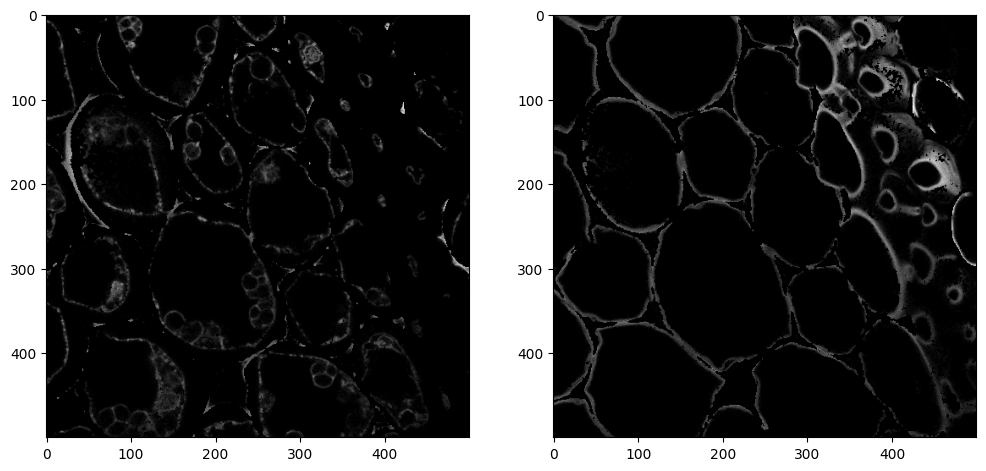

In [4]:
from matplotlib.path import Path

roi_path_1 = Path(phasor_roi_1)
roi_path_2 = Path(phasor_roi_2)

# Stack g and s into pixel coordinate pairs
gs_coords = np.stack((phasor_calibrated_smoothed.real.ravel(), phasor_calibrated_smoothed.imag.ravel()), axis=-1)


# Check which coordinates fall inside the ROI
inside_mask_flat_1 = roi_path_1.contains_points(gs_coords)
inside_mask_flat_2 = roi_path_2.contains_points(gs_coords)
# Reshape to image shape
phasor_pixel_mask_1 = inside_mask_flat_1.reshape(count.shape)
phasor_pixel_mask_2 = inside_mask_flat_2.reshape(count.shape)
masked_img_1 = np.zeros_like(count)
masked_img_2 = np.zeros_like(count)
masked_img_1[phasor_pixel_mask_1] = count[phasor_pixel_mask_1]
masked_img_2[phasor_pixel_mask_2] = count[phasor_pixel_mask_2]
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(masked_img_1,cmap='gray')
ax[1].imshow(masked_img_2,cmap='gray')



In [5]:
print(phasor_pixel_mask_1.shape)
print(phasor_pixel_mask_1.dtype)
print(phasor_pixel_mask_1.__class__)

(500, 500)
bool
<class 'numpy.ndarray'>


Get phasors from the masked image

In [6]:
from ptuio.utils import average_phasor

phasor_calibrated_masked_1 = phasor_calibrated * phasor_pixel_mask_1
phasor_calibrated_masked_2 = phasor_calibrated * phasor_pixel_mask_2

phasor_calibrated_masked_1_averaged = average_phasor(phasor = phasor_calibrated_masked_1, photon_count = masked_img_1)
phasor_calibrated_masked_2_averaged = average_phasor(phasor = phasor_calibrated_masked_2, photon_count = masked_img_2)

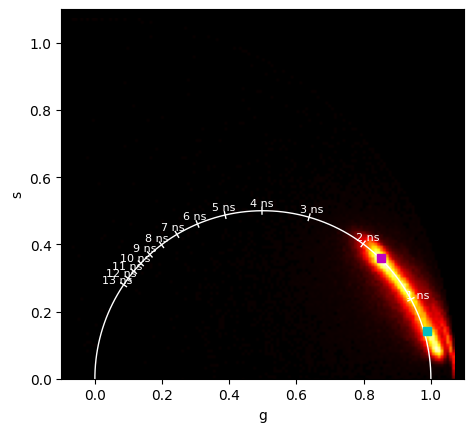

In [7]:
H, xedges, yedges = np.histogram2d(g_calibrated_smooth_valid, s_calibrated_smooth_valid, bins=250)
# Create alpha mask: transparent where H == min(H)
alpha = np.ones_like(H, dtype=float)
alpha[H == H.min()] = 0.0

fig, ax = plt.subplots()

im = ax.imshow(
    H.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='hot',
    aspect='equal',
    alpha=alpha.T  # transpose alpha to match H.T
)

draw_unitary_circle(ax,sync_rate=repetition_rate)

ax.plot(phasor_calibrated_masked_1_averaged.real,phasor_calibrated_masked_1_averaged.imag,'cs')
ax.plot(phasor_calibrated_masked_2_averaged.real,phasor_calibrated_masked_2_averaged.imag,'ms')



ax.set_facecolor("black")
# plt.colorbar(im, ax=ax)
plt.show()